In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os

%load_ext autoreload
%autoreload 2

/Users/bensorscher/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from model import Model
from trainer import Trainer
from data_manager import DataManager
from hd_cells import HDCells
from place_cells import PlaceCells
from options import get_options

In [3]:
flags = get_options()

In [4]:
def load_checkpoints(sess):
    saver = tf.train.Saver(max_to_keep=2)
    checkpoint_dir = flags.save_dir + "/checkpoints"
    
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint and checkpoint.model_checkpoint_path:
        # checkpointからロード
        saver.restore(sess, checkpoint.model_checkpoint_path)
        # ファイル名から保存時のstep数を復元
        tokens = checkpoint.model_checkpoint_path.split("-")
        step = int(tokens[1])
        print("Loaded checkpoint: {0}, step={1}".format(checkpoint.model_checkpoint_path, step))
        return saver, step+1
    else:
        print("Could not find old checkpoint")
        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        return saver, 0

In [5]:
def save_checkponts(sess, saver, global_step):
    checkpoint_dir = flags.save_dir + "/checkpoints"
    saver.save(sess, checkpoint_dir + '/' + 'checkpoint', global_step=global_step)
    print("Checkpoint saved")

In [6]:
def train(sess, trainer, saver, summary_writer, test_summary_writer, start_step):
    for i in range(start_step, flags.steps):
        # 学習
        trainer.train(sess, summary_writer, test_summary_writer, step=i, flags=flags)
        
        if i % flags.save_interval == flags.save_interval-1:
            # 保存
            save_checkponts(sess, saver, i)

In [7]:
np.random.seed(1)

In [8]:
if not os.path.exists(flags.save_dir):
    os.mkdir(flags.save_dir)

In [9]:
data_manager = DataManager()
place_cells = PlaceCells()
hd_cells = HDCells()
data_manager.prepare(place_cells, hd_cells)

In [10]:
model = Model(place_cell_size=place_cells.cell_size,
              hd_cell_size=hd_cells.cell_size,
              sequence_length=flags.sequence_length)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
trainer = Trainer(data_manager, model, flags)

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [13]:
# For Tensorboard log
log_dir = flags.save_dir + "/log/train"
test_log_dir = flags.save_dir + "/log/test"
summary_writer = tf.summary.FileWriter(log_dir, sess.graph)
test_summary_writer = tf.summary.FileWriter(test_log_dir, sess.graph)

In [59]:
# Load checkpoints
saver, start_step = load_checkpoints(sess)

INFO:tensorflow:Restoring parameters from saved/checkpoints/checkpoint-9999
Loaded checkpoint: saved/checkpoints/checkpoint-9999, step=9999


In [95]:
flags.steps = 15000
start_step = 10000

In [96]:
# Train
train(sess, trainer, saver, summary_writer, test_summary_writer, start_step)

10000
11000
12000
13000
14000
Checkpoint saved


## Visualize head direction cells

In [97]:
import h5py
f = h5py.File('mouse_simulation_data.h5', 'r')
x = f['x']
y = f['y']
head_dir = f['head_dir']

In [98]:
test_length = 750

# Get ground truth head direction
head_dir = f['head_dir']
head_dir = head_dir[:test_length]

# Get hd cells ground truth
hd_cells_gt = []
for gt in data_manager.hd_outputs[:test_length]:
    dir_gt = hd_cells.get_nearest_hd(gt)
    hd_cells_gt.append(dir_gt)

In [99]:
# Prepare batch
batch_size = 10
sequence_length = 100
index=0
out = data_manager.get_confirm_batch(batch_size, sequence_length, index)
inputs_batch, place_init_batch, hd_init_batch, place_pos_batch = out

# Run session
hd_output_result = sess.run(
    model.hd_output_result,
    feed_dict = {
        model.inputs : inputs_batch,
        model.place_init : place_init_batch,
        model.hd_init : hd_init_batch,
        model.keep_prob : 1.0
    })

# Extract hd cell predictions
hd_cells_predicted = []
for hd in hd_output_result[:test_length]:
    dir_pred = hd_cells.get_nearest_hd(hd)
    hd_cells_predicted.append(dir_pred)

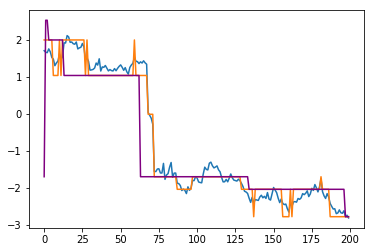

In [101]:
# Plot comparison
plt.plot(head_dir[:200])
plt.plot(hd_cells_gt[:200])
plt.plot(hd_cells_predicted[:200], c='purple')

### Visualize trajectory

In [102]:
import h5py
f = h5py.File('mouse_simulation_data.h5', 'r')
x = f['x']
y = f['y']

(-1.1, 1.1)

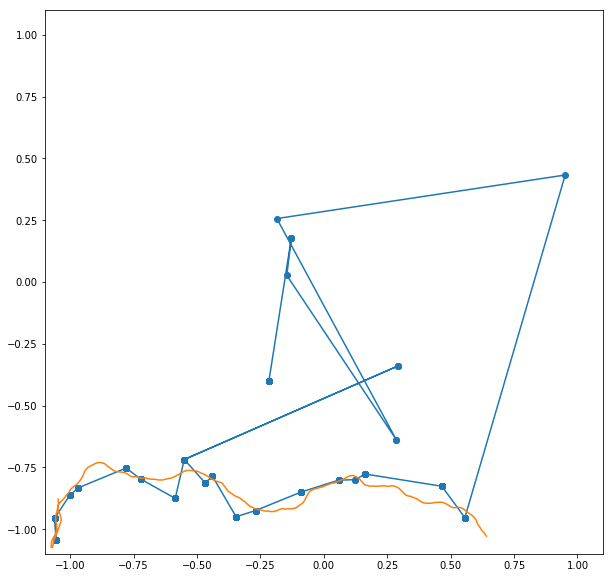

In [110]:
batch_size = 10
sequence_length = 100
index=0
out = data_manager.get_confirm_batch(batch_size, sequence_length, index)
inputs_batch, place_init_batch, hd_init_batch, place_pos_batch = out
            
place_output_result = sess.run(
    model.place_outputs_result,
    feed_dict = {
        model.inputs : inputs_batch,
        model.place_init : place_init_batch,
        model.hd_init : hd_init_batch,
        model.keep_prob : 1.0
    })
out_x = []
out_z = []

for c in place_output_result[:750]:
    # c=(256,)
    cell_pos = place_cells.get_nearest_cell_pos(c)
    out_x.append(cell_pos[0])
    out_z.append(cell_pos[1])
    
out_x_gt = []
out_z_gt = []
for c in data_manager.place_outputs[750:1500]:
    # c=(256,)
    cell_pos = place_cells.get_nearest_cell_pos(c)
    out_x_gt.append(cell_pos[0])
    out_z_gt.append(cell_pos[1])
    
plt.figure(figsize=(10, 10))
# plt.plot(out_x_gt, out_z_gt, "o-")
plt.plot(out_x, out_z, "o-")
plt.plot(x[:750], y[:750])
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)

### Can we read out the grid cell activations?

In [15]:
batch_size = 10
sequence_length = 100
resolution = 20
#maze_extents = 4.5
maze_extents = 750

activations = np.zeros([512, resolution, resolution], dtype=np.float32) # (512, 32, 32)
counts  = np.zeros([resolution, resolution], dtype=np.int32)        # (32, 32)

index_size = data_manager.get_confirm_index_size(batch_size, sequence_length)

for index in range(index_size):
    out = data_manager.get_confirm_batch(batch_size, sequence_length, index)
    inputs_batch, place_init_batch, hd_init_batch, place_pos_batch = out
            
    place_pos_batch = np.reshape(place_pos_batch, [-1, 2])
    # (1000, 2)
    
    g = sess.run(
            model.g,
            feed_dict = {
                model.inputs : inputs_batch,
                model.place_init : place_init_batch,
                model.hd_init : hd_init_batch
            })
    
        
    for i in range(batch_size * sequence_length):
        pos_x = place_pos_batch[i,0]
        pos_z = place_pos_batch[i,1]
        x = (pos_x + maze_extents) / (maze_extents * 2) * resolution
        z = (pos_z + maze_extents) / (maze_extents * 2) * resolution
        if x >=0 and x < resolution and z >=0 and z < resolution:
            counts[int(x), int(z)] += 1
            activations[:, int(x), int(z)] += np.abs(g[i, :])

for x in range(resolution):
    for y in range(resolution):
        if counts[x, y] > 0:
            activations[:, x, y] /= counts[x, y]



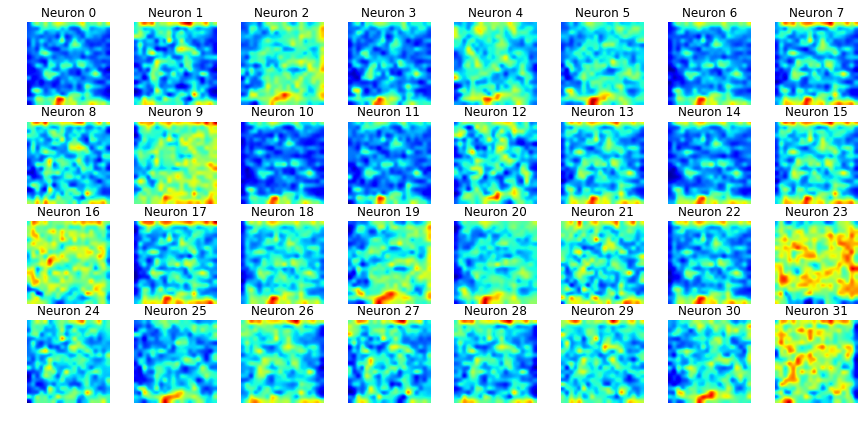

In [16]:
activations = (activations - np.min(activations)) / (np.max(activations) - np.min(activations))

# hidden_size = 512
hidden_size = 32

plt.figure(figsize=(15, int(30 * hidden_size / 128)))
for i in range(hidden_size):
    plt.subplot(hidden_size//8, 8, 1 + i)
    plt.title('Neuron ' + str(i))
    plt.imshow(activations[i,:,:], interpolation="gaussian", cmap="jet")
    plt.axis('off')    
plt.show()

# Tests

In [13]:
EPISODE_LENGTH = 750
sequence_length = 100
episode_size = (data_manager.test_linear_velocities.shape[0]+1) // EPISODE_LENGTH

#get batch
episode_index = np.random.randint(0, episode_size)
pos_in_episode = np.random.randint(0, EPISODE_LENGTH-(sequence_length+1))

i=0
pos = episode_index * EPISODE_LENGTH + pos_in_episode
inputs_batch = data_manager.inputs[pos:pos+sequence_length,:]

In [14]:
ego_velocity = inputs_batch[:,0]
theta_x = inputs_batch[:,1]
theta_y = inputs_batch[:,2]
x = data_manager.pos_x[pos+1:pos+sequence_length+1]
y = data_manager.pos_y[pos+1:pos+sequence_length+1]
head_dir = data_manager.head_dir[pos+1:pos+sequence_length+1]
position = np.asarray([x,y]).T

In [43]:
idx = 3
#Can we reconstuct head direction from angular velocity?
head_dir_guess = head_dir[idx-1] + np.arctan(theta_y[idx]/theta_x[idx])
print('head dir guess = ' + str(head_dir_guess))
print('true head dir  = ' + str(head_dir[idx]))

#Can we reconstruct position from ego_v and angular velocity?
position_guess = position[idx-1] + ego_velocity[idx]*np.asarray([np.cos(head_dir[idx]), np.sin(head_dir[idx])])
print('position guess =' + str(position_guess))
print('true position = ' + str(position[idx]))

head dir guess = 2.797346941675321
true head dir  = 2.7973469501333907
position guess =[-0.74140106 -0.78767517]
true position = [-0.7388505  -0.78817495]


In [51]:
data_manager.place_outputs.shape

(100000, 256)

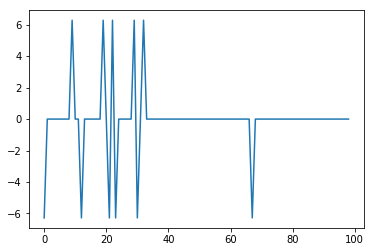

In [38]:
plt.plot(head_dir[:-1] + np.arctan(theta_y[1:]/theta_x[1:]) - head_dir[1:])


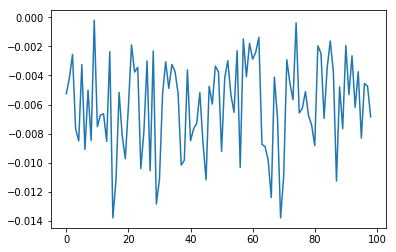

In [42]:
plt.plot(position[:-1,0] + ego_velocity[1:]*np.cos(head_dir[1:]) - position[1:,0])

### print(head_dir - np.pi)